In [8]:
import numpy as np
import matplotlib as plt
from keras.models import Sequential, load_model
from PIL import Image
import timeit,time
import math
import pandas as pd
import matplotlib.pyplot as plt

from skimage import measure
from scipy import ndimage as ndi
from skimage import feature

In [9]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'models/' + 'EDGEnet2_round_L1_epoch_4.h5')

In [8]:
sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
#Xis = [10, 30, 40]
Xis = [10]
#alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alphas = [0.1]
widths = [20, 30]
#noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]
noises = [200]



testsize = len(sigmas)*len(Xis)*len(alphas)*len(widths)*len(noises)*2
print('Testsize: ', testsize)


df = pd.DataFrame(columns = ['noise', 'sigma', 'alpha', 'Xi', 'width', 'space', 'MSE_noise', \
                             'PSNR_noise', 'Pred_time', 'i_leftline_sigma', 'ledge_pred_sigma',\
                             'i_rightline_sigma',  'redge_pred_sigma',\
                              'lpred_error', 'rpred_error'])
                             

count = 0
for sigma in sigmas:
    for alpha in alphas:
        for Xi in Xis:
            for width in widths:
                for s in range(2):
                    for noise in noises:
                        space = math.floor(width*2**s)
                        shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 
                        
                        original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
                        noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
                        linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
                        linescan = []
                        
                        with open(linescan_file,'r') as f:
                            for i, line in enumerate(f):
                                if i < 3000:
                                    a, b = line.split(',')
                                    linescan.append(float(b))
                        
                        linescan = linescan[:2048]
                        
                        leftline = np.array(linescan[:1024]) 
                        rightline = linescan[1024:]
                        rightline.reverse()
                        rightline = np.array(rightline)

                        leftline = leftline + shift           # add shift to linescan
                        rightline = rightline + shift         # add shift to linescan
                        
                        im = np.array(Image.open(original_file))
                        imnoisy = np.array(Image.open(noisy_file))
                        
                        im = im/256
                        imnoisy = imnoisy/256
                        imnoisy = imnoisy.reshape(1,1024,64,1)
                        im = im.reshape(1,1024,64,1)
                        
                        start = time.time()
                        linepredict = model.predict(imnoisy)
                        
                        prediction_time = time.time() - start
                        
                        linepredict = linepredict.reshape(1024,2)
                        
                        imnoisy = imnoisy.reshape(1024,64)
                        im = im.reshape(1024,64)
                        imnoisy = imnoisy.astype(float)
                        im = im.astype(float)
                        
                        mse_noisy = (256**2)*((im - imnoisy) ** 2).mean()
                        
                        psnr_noisy = measure.compare_psnr(im,imnoisy)
                        
                        
                        ledge_pred = (linepredict*64)[:,0].round()
                        redge_pred = (linepredict*64)[:,1].round()
                        
                        
                        #lpred_rmse = np.sqrt(((leftline.astype(int) - ledge_pred)**2).mean())
                        #rpred_rmse = np.sqrt(((rightline.astype(int) - redge_pred)**2).mean())
                        lline_std = leftline.round().std()/2
                        rline_std = rightline.round().std()/2
                        lpred_std = (ledge_pred).std()/2
                        rpred_std = (redge_pred).std()/2
                        lerror = (lline_std - lpred_std)*100/lline_std
                        rerror = (rline_std - rpred_std)*100/rline_std
                        
                        df.loc[count] = [noise, sigma, alpha, Xi, width, space, mse_noisy, \
                                         psnr_noisy, prediction_time, \
                                         lline_std, lpred_std,\
                                         rline_std, rpred_std,\
                                         lerror, rerror]
                        
                        count += 1
                        
print("Test count: ", count)

Testsize:  32
Test count:  32


In [9]:
print(df)

    noise  sigma  alpha    Xi  width  space  MSE_noise  PSNR_noise  Pred_time  \
0   200.0    0.4    0.1  10.0   20.0   20.0  78.874237   29.195448   2.438454   
1   200.0    0.4    0.1  10.0   20.0   40.0  78.937790   29.191950   2.410160   
2   200.0    0.4    0.1  10.0   30.0   30.0  87.000046   28.769604   2.417241   
3   200.0    0.4    0.1  10.0   30.0   60.0  85.475357   28.846390   2.538191   
4   200.0    0.6    0.1  10.0   20.0   20.0  80.693665   29.096405   2.371456   
5   200.0    0.6    0.1  10.0   20.0   40.0  78.889496   29.194607   2.337290   
6   200.0    0.6    0.1  10.0   30.0   30.0  88.053833   28.717317   2.407065   
7   200.0    0.6    0.1  10.0   30.0   60.0  89.955612   28.624517   2.370790   
8   200.0    0.8    0.1  10.0   20.0   20.0  81.955170   29.029036   2.328459   
9   200.0    0.8    0.1  10.0   20.0   40.0  79.285904   29.172839   2.330015   
10  200.0    0.8    0.1  10.0   30.0   30.0  90.243546   28.610638   2.329842   
11  200.0    0.8    0.1  10.

[11160, 22320, 33480, 44640]


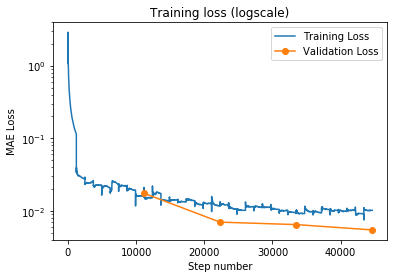

range(11160, 55800, 11160)


In [11]:
%matplotlib inline
logfile = path + 'neural_nets/EDGEnet2_round_L1_epoch4.748390'
losses = []
validation_score = []
with open(logfile,'r') as f:
    for line in f:
        if 'loss' in line:
            losses.append(float(line.split()[-1]))
        if 'Validation score' in line:
            validation_score.append(float(line.split()[-1]))

num_of_runs = range(len(losses))
val_runs = range(len(losses)//4, len(losses) + len(losses)//4, len(losses)//4)
print(list(val_runs))
plt.plot(num_of_runs, losses, label = 'Training Loss')
plt.plot(val_runs, validation_score, '-o', label = 'Validation Loss')
plt.ylabel('MAE Loss')
plt.xlabel('Step number')
plt.title('Training loss (logscale)')
plt.yscale('log')
plt.savefig(path + 'Training_loss.png')
plt.legend()
plt.show()
print(val_runs)